IA & Data science (LU3IN0226) -- 2024-2025
--------
*&copy; Equipe pédagogique: Christophe Marsala, Olivier Schwander, Jean-Noël Vittaut.*


#  Semaine 2 : algorithme des k plus proches voisins

<font size="+1" color="RED">**[Q]**</font> **Indiquer dans la boîte ci-dessous vos noms et prénoms :**

Yanis Saadi Dit Saada
Ines Harraoui

<font color="RED" size="+1">**[Q]**</font> **Renommer ce fichier ipython**

Tout en haut de cette page, cliquer sur <tt>tme-02</tt> et rajouter à la suite de <tt>tme-02</tt> les noms des membres du binômes séparés par un tiret.

<font color="RED" size="+1">IMPORTANT: soumission de votre fichier final</font>

**Nom à donner au fichier à poster** : *Nom1_Nom2.ipynb* 
- *Nom1* et *Nom2* : noms des membres du binôme
- ne pas compresser ou faire une archive: il faut rendre le fichier ipython tel quel, éventuellement, si vous avez d'autres fichiers vous les rendez séparément.

**Echancier pour la soumission de votre compte-rendu:**
- le compte-rendu d'une séance doit être remis obligatoirement <font color="RED">avant la séance suivante</font>.

**Le compte-rendu est soumis sur la page Moodle.**

## Présentation ##

Dans ce TME, nous allons mettre en place une "architecture" de code nous permettant petit à petit de tester tout au long du semestre différents modèles d'apprentissage supervisé. Dans nos séances, nous allons nous restreindre au cas binaire où les étiquettes des exemples sont $+1$ ou $-1$.


### Objectifs de ce TME

Le travail à réaliser est le suivant :
- continuer à apprendre à (bien) utiliser jupyter notebook
- générer aléatoirement des datasets jouets pour expérimenter
- se familiariser avec la classe `Classifier` et implémenter un premier classifieur simple
- implémenter l'algorithme des $k$ plus proches voisins
- réaliser des expérimentations pour étudier les performances de cet algorithme

### Importations et quelques commandes utiles:

Les imports suivants seront généralement nécessaires pour nos séances.

Notez que les numéros de version indiqués ne sont pas forcément ceux de votre environnement

In [50]:
# - - - - - - - - - - - - - - - - - -
# imports utiles
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mtpl
%matplotlib inline  

import math
import time
import sys

# Les instructions suivantes sont utiles pour recharger automatiquement 
# le code modifié dans les librairies externes
%load_ext autoreload
%autoreload 2

# - - - - - - - - - - - - - - - - - -
# Information sur l'environnent utilisé ici:
print("Version python et des librairies:")
print("\tPython ",sys.version)
print("\tpandas: ",pd.__version__)
print("\tnumpy: ",np.__version__)
print("\tmatplotlib: ",mtpl.__version__)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Version python et des librairies:
	Python  3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
	pandas:  2.0.3
	numpy:  1.24.3
	matplotlib:  3.7.2


Remarque: pour savoir si une librairie est installée dans votre environnement:

In [51]:
pip list | grep numpy

Note: you may need to restart the kernel to use updated packages.


'grep' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.


Si vous souhaitez utiliser une librairie qui n'est pas installé, revoyez le TME 1 qui donne l'instruction d'installation par pip.

**Remarque**: la commande `grep` n'est pas connue si vous êtes sous Windows, faites simplement : `pip list` et cherchez `numpy` dans le résultat obtenu.

**Remarques :**
Sauf indication contraire, les vecteurs et les matrices seront représentés par des `np.ndarray` numpy que l'on construit par la fonction `np.array()`.

La concaténation de vecteurs pour contruire une matrice s'obtient à l'aide de la fonction `np.vstack`.

In [52]:
# Exemples :

vecteur_1 = np.array([0, 1.5, 4.2])
print("Type de vecteur_1: ",type(vecteur_1))
print("vecteur_1 : ",vecteur_1)

vecteur_2 = np.array([1.1, 3.8, 20.01])
print("Type de vecteur_2: ",type(vecteur_2))
print("vecteur_2 : ",vecteur_2)

vecteur_3 = vecteur_1 + vecteur_2
print("Type de vecteur_3: ",type(vecteur_3))
print("vecteur_3 : ",vecteur_3)

# Exemple d'utilisation de vstack (pour plus de détails, voir la doc numpy sur le web)
resultat_1 = np.vstack( (vecteur_1, vecteur_2, vecteur_3) )
print("Type de matrice_1: ",type(resultat_1))
print("resultat_1 : \n",resultat_1)


# On peut aussi utiliser concatenante (pour plus de détails, voir la doc numpy sur le web)
resultat_2 = np.concatenate( (vecteur_1, vecteur_2, vecteur_3) )
print("Type de resultat_2: ",type(resultat_2))
print("resultat_2 : \n",resultat_2)


Type de vecteur_1:  <class 'numpy.ndarray'>
vecteur_1 :  [0.  1.5 4.2]
Type de vecteur_2:  <class 'numpy.ndarray'>
vecteur_2 :  [ 1.1   3.8  20.01]
Type de vecteur_3:  <class 'numpy.ndarray'>
vecteur_3 :  [ 1.1   5.3  24.21]
Type de matrice_1:  <class 'numpy.ndarray'>
resultat_1 : 
 [[ 0.    1.5   4.2 ]
 [ 1.1   3.8  20.01]
 [ 1.1   5.3  24.21]]
Type de resultat_2:  <class 'numpy.ndarray'>
resultat_2 : 
 [ 0.    1.5   4.2   1.1   3.8  20.01  1.1   5.3  24.21]


## Étape 1: dataset

La première étape consiste à construire un ensemble d'exemples d'apprentissage que l'on appelle par la suite simplement *dataset*. Un dataset est un ensemble de couples $\{(\mathbf{x}_1,y_1),...,(\mathbf{x}_n,y_n)\}$. 

Pour nos implémentations, les $\mathbf{x}_i$ et $y_i$ seront stockés sous la forme de <code>ndarray</code> Numpy.


### Génération de données ''Jouet''

Nous allons pour l'instant nous intéresser à des datasets "jouet" générés selon des distributions choisies à la main.  Ces jeux de données nous permettrons de tester nos algorithmes.

Pour pouvoir visualiser nos données, nous allons nous restreindre à des dataset en 2 dimensions pour la description (entrée $\mathbf{x}_i$ ) et l'étiquette (sortie $y_i$). 
On aura donc ici: $\mathbf{x}_i \in \mathbb{R}^2$ et $y_i \in \{-1;+1\}$.

#### Tirage aléatoire selon une loi uniforme

Commençons par un dataset dont les exemples sont générés par un tirage aléatoire selon une loi uniforme.

Pour cela, nous utiliserons la fonction numpy `random.uniform`:

voir la doc: https://numpy.org/doc/stable/reference/random/generated/numpy.random.uniform.html

Cette fonction renvoie :
- soit un nombre réel obtenu par un tirage aléatoire
- soit `ndarray` dont les dimensions ont été précisées et qui contient un ensemble de nombres réels tirés aléatoirement

In [53]:
np.random.uniform()  # rend un réel aléatoire de l'intervalle [0.0, 1.0[ (tirage uniforme)

0.7319939418114051

In [54]:
np.random.uniform(-7,5) # rend un réel aléatoire de l'intervalle [-7, 5[ (tirage uniforme)

0.1839018103644392

In [55]:
np.random.uniform(-7,5,(4,3)) # rend un tableau de 4x3 réels aléatoires pris dans [-7, 5[ (tirage uniforme)

array([[-5.12777631, -5.12806576, -6.30299665],
       [ 3.39411375,  0.21338014,  1.49687093],
       [-6.75298607,  4.63891823,  2.98931169],
       [-4.45193067, -4.81810039, -4.79914588]])

Pour générer aléatoirement les étiquettes (aussi appelées <i>labels</i> ou <i>classes</i>) (qui sont donc des valeurs de {-1, +1}), une contrainte supplémentaire s'ajoute: on souhaite que dans le dataset, il y ait autant d'exemples de chaque classe.

Ainsi, si on veut générer un ensemble de 20 labels de telle sorte qu'il y ait exactement 10 valeurs -1 et 10 valeurs +1 dans cet ensemble, la méthode la plus simple est de construire une liste en additionnant une liste de 10 valeurs -1 et une liste de 10 valeurs +1. Pour notre implémentation, cette liste doit ensuite être convertie en `ndarray`.

In [56]:
Lnd = np.array([-1 for i in range(0,10)] + [+1 for i in range(0,10)])
print("type :", type(Lnd))
Lnd

# IMPORTANT POUR LA SUITE : on met les -1 avant les +1.

type : <class 'numpy.ndarray'>


array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1])

Lors de la mise au point d'un programme qui utilise l'aléatoire, il est important de pouvoir travailler sur des séquences aléatoires qui soient toujours les mêmes.
Pour cela, on doit préciser une initialisation de la séquence aléatoire, cela se fait en utilisant la commande numpy `random.seed` qui permet d'initialiser la *graine* du générateur de valeurs aléatoire:

https://numpy.org/doc/stable/reference/random/generated/numpy.random.seed.html

Ainsi, avec la même valeur donnée comme graine, on obtiendra toujours la même séquence de tirages aléatoires.

Par exemple :

In [57]:
np.random.seed(42)
np.random.uniform(-10,10,10)

array([-2.50919762,  9.01428613,  4.63987884,  1.97316968, -6.87962719,
       -6.88010959, -8.83832776,  7.32352292,  2.02230023,  4.16145156])

In [58]:
# on relance pour vérifier que le résultat est identique: 
np.random.seed(42)
np.random.uniform(-10,10,10)

array([-2.50919762,  9.01428613,  4.63987884,  1.97316968, -6.87962719,
       -6.88010959, -8.83832776,  7.32352292,  2.02230023,  4.16145156])

<font color="RED" size="+1">**[Q]**</font> En utilisant la fonction précédente, créer 2 variables :
- `data1_desc` : qui est un tableau de 100 exemples de dimension 2 dont les valeurs pour chaque dimension sont tirées aléatoirement dans l'intervalle [-5,5[ 
- `data1_label` : qui est un tableau d'entiers de {-1,+1}  tel qu'il y ait 50 valeurs -1 suivi de 50 valeurs +1.


In [59]:
np.random.seed(42)   # on prend 42 comme graine

# ------------------------ Décommenter et compléter les lignes suivantes :
data1_desc = np.random.uniform(-5,5,(100,2))

data1_label = Lnd = np.array([-1 for i in range(0,50)] + [+1 for i in range(0,50)])




In [60]:
len(data1_desc) # nombre de lignes de data_desc

100

In [61]:
data1_desc.shape # Dimensions de data_desc

(100, 2)

In [62]:
print("Les 5 premières lignes de data1_desc: \n", data1_desc[0:5,:])
print("Les labels correspondant à ces 5 lignes: \n",data1_label[0:5])

Les 5 premières lignes de data1_desc: 
 [[-1.25459881  4.50714306]
 [ 2.31993942  0.98658484]
 [-3.4398136  -3.4400548 ]
 [-4.41916388  3.66176146]
 [ 1.01115012  2.08072578]]
Les labels correspondant à ces 5 lignes: 
 [-1 -1 -1 -1 -1]


In [63]:
# maximum des valeurs par colonne:
data1_desc.max(0)

array([4.85650454, 4.86886937])

In [64]:
# minimum des valeurs par colonne:
data1_desc.min(0)

array([-4.94477883, -4.83412171])

<font color="RED" size="+1">**[Q]**</font> Ecrire la fonction `genere_dataset_uniform` qui prend en argument le nombre de dimensions $d$, **le nombre $n_c$  d'exemples de chaque classe**, ainsi que 2 valeurs pour les bornes inférieure et supérieure des valeurs de description, et qui renvoie un tuple dont le premier composant est un `ndarray` contenant $2*n_c$  vecteurs de description générés aléatoirement en suivant une loi uniforme et le deuxième composant est un `ndarray` contenant les labels correspondant (en respectant l'équirépartition des labels). Les $n_c$ premiers exemples auront le label $-1$, les suivants auront le label $+1$.

On fait l'hypothèse que la borne inférieure est plus petite que la borne supérieure.



In [65]:
# ------------------------ A COMPLETER :
def genere_dataset_uniform(d, nc, binf=-1, bsup=1):
    """ int * int * float^2 -> tuple[ndarray, ndarray]
        Hyp: n est pair
        d: nombre de dimensions de la description
        nc: nombre d'exemples de chaque classe
        les valeurs générées uniformément sont dans [binf,bsup]
    """
    
    data_desc = np.random.uniform(binf,bsup,(2*nc,d))

    data_label = np.array([-1 for i in range(0,nc)] + [+1 for i in range(0,nc)])

    return (data_desc,data_label)

In [66]:
np.random.seed(42)   # on prend 42 comme graine

# Génération d'un dataset de 20 exemples :
data2_desc, data2_label = genere_dataset_uniform(2,10,-5,5)

print("Dimensions de data2_desc: ",data2_desc.shape)
print("Nombre de lignes de data2_lab: ",len(data2_label))

Dimensions de data2_desc:  (20, 2)
Nombre de lignes de data2_lab:  20


In [67]:
print("Les 5 premières lignes de data2_desc: \n", data2_desc[0:5,:])
print("Les labels correspondant à ces 5 lignes: \n",data2_label[0:5])


Les 5 premières lignes de data2_desc: 
 [[-1.25459881  4.50714306]
 [ 2.31993942  0.98658484]
 [-3.4398136  -3.4400548 ]
 [-4.41916388  3.66176146]
 [ 1.01115012  2.08072578]]
Les labels correspondant à ces 5 lignes: 
 [-1 -1 -1 -1 -1]


**Remarque:** on va utiliser ce dataset `data2` de 20 exemples par la suite pour mettre au point nos fonctions.


Un dataset en 2 dimensions peut être affiché en utilisant les fonctions de la librairie `matplotlib` et plus précisément la fonction `pyplot.scatter` permettant de dessiner un nuage de points: 

https://matplotlib.org/2.0.2/api/pyplot_api.html

Par exemple :

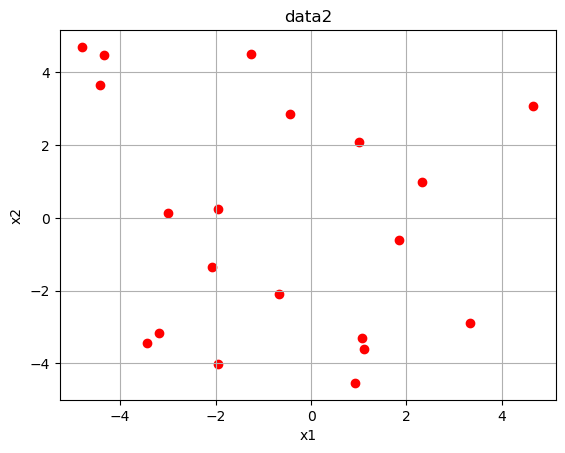

In [68]:
# Tracé de l'ensemble des exemples :
plt.scatter(data2_desc[:,0],data2_desc[:,1],marker='o',color='red')

# Informations d'affichage :
plt.title("data2")
plt.xlabel("x1")
plt.ylabel("x2")
plt.grid()  # Grille: à mettre, ou pas

# Visualisation du résultat
plt.show()

In [69]:
# Remarque : le nom des couleur est standardisé, pour connaître des noms de couleur possible:

# ---------------> Décommenter la ligne suivante 
mpl.colors.cnames

# éventuellement, vous pouvez utiliser internet pour visualiser ces couleurs...

NameError: name 'mpl' is not defined

Il est intéressant de  faire un affichage des points qui tient compte de leur étiquette et utiliser des couleurs différentes pour afficher les points. Pour faire cela, il faut commencer par séparer les exemples selon leur étiquette : ceux de label -1 et ceux de label +1. On utilise pour cela la puissance des `ndarray` pour faire des sélections (slices).

In [41]:
# Extraction des exemples de classe -1:
data2_negatifs = data2_desc[data2_label == -1]
# Extraction des exemples de classe +1:
data2_positifs = data2_desc[data2_label == +1]

On peut alors afficher les points en leur donnant une marque (''marker'') différente (la couleur du marqueur est déterminée automatiquement).

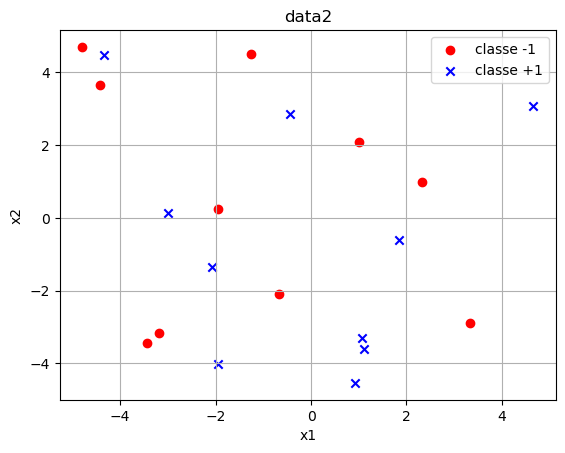

In [51]:
# Tracé de l'ensemble des exemples :
plt.scatter(data2_negatifs[:,0],data2_negatifs[:,1],marker='o', color="red", label='classe -1') # 'o' rouge pour la classe -1
plt.scatter(data2_positifs[:,0],data2_positifs[:,1],marker='x', color="blue", label='classe +1') # 'x' bleu pour la classe +1

# Informations d'affichage :
plt.title("data2")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.grid()  # Grille: à mettre, ou pas

# Visualisation du résultat
plt.show()

<font color="RED" size="+1">**[Q]**</font> En utilisant les instructions précédentes, écrire la fonction `plot2DSet` qui, étant donné deux `ndarray`, un donnant des descriptions et l'autre les labels correspondants, affiche une représentation graphique de ce jeu de données.

In [21]:
# ------------------------ A COMPLETER :
def plot2DSet(desc,labels,nom_dataset= "Dataset", avec_grid=False):    
    """ ndarray * ndarray * str * bool-> affichage
        nom_dataset (str): nom du dataset pour la légende
        avec_grid (bool) : True si on veut afficher la grille
        la fonction doit utiliser la couleur 'red' pour la classe -1 et 'blue' pour la +1
    """

    data2_negatifs = desc[labels == -1]
    data2_positifs = desc[labels == +1]

    # Tracé de l'ensemble des exemples :
    plt.scatter(data2_negatifs[:,0],data2_negatifs[:,1],marker='o', color="red", label='classe -1') # 'o' rouge pour la classe -1
    plt.scatter(data2_positifs[:,0],data2_positifs[:,1],marker='x', color="blue", label='classe +1') # 'x' bleu pour la classe +1

    # Informations d'affichage :
    plt.title("data2")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.grid()  # Grille: à mettre, ou pas

    # Visualisation du résultat
    plt.show()



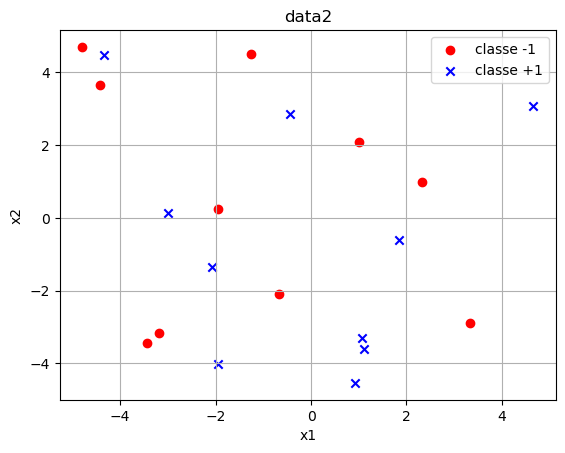

In [ ]:
# si tout est ok, l'appel suivant affiche exactement la même chose que précédemment
plot2DSet(data2_desc,data2_label,"data2", True)

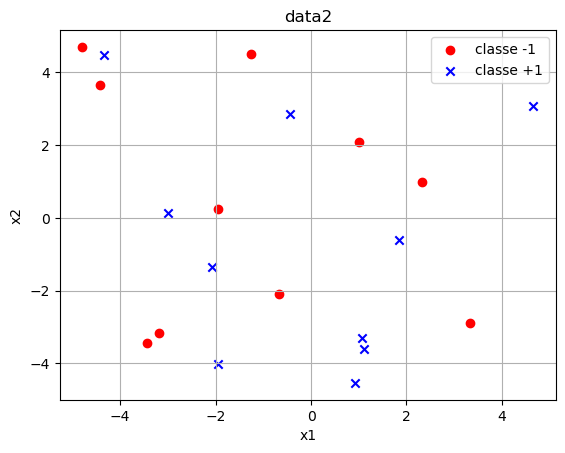

In [23]:
# Affichage sans la grille:
plot2DSet(data2_desc,data2_label)

#### Tirage aléatoire selon une loi normale


Pour obtenir un dataset plus ''réaliste'', la loi uniforme n'est pas idéale, il est préférable de générer des dataset en utilisant un tirage aléatoire selon une loi normale (ie. représentée par une gaussienne).

Pour cela, nous utiliserons la fonction numpy `random.multivariate_normal` :

https://numpy.org/doc/stable/reference/random/generated/numpy.random.multivariate_normal.html


Dans ce qui suit, on considère toujours un dataset en 2 dimensions (entrée) et 1 dimension (sortie) comme précédemment.

La façon de procéder avec un tel tirage est différente de celle utilisée dans le cas uniforme: 
- on commence par tirer aléatoirement tous les exemples de la classe -1
- puis on tire aléatoirement tous les exemples de la classe +1
- on fusionne ces 2 ensembles en les mettant bout à bout
- le tableau des labels est donc facile à construire: d'abord les -1 puis les +1


<font color="RED" size="+1">**[Q]**</font> Ecrire la fonction <tt>genere_dataset_gaussian</tt> qui, étant donné 5 arguments:
- `positive_center` est le centre de la gaussienne des points positifs (vecteur de taille 2)
- `positive_sigma` est la variance de la gaussienne des points positifs (sous forme de matrice 2*2)
- `negative_center` est le centre de la gaussienne des points négative (vecteur de taille 2)
- `negative_sigma` est la variance de la gaussienne des points négative (sous forme de matrice 2*2)
- `nc` est le nombre de points de chaque classe à générer

rend un dataset généré aléatoirement en suivant une loi normale.

In [24]:
# ------------------------ A COMPLETER :

def genere_dataset_gaussian(positive_center, positive_sigma, negative_center, negative_sigma, nc):
    """ les valeurs générées suivent une loi normale
        rend un tuple (data_desc, data_labels)
    """
    data_negatifs = np.random.multivariate_normal(negative_center, negative_sigma, nc)
    data_positifs = np.random.multivariate_normal(positive_center, positive_sigma, nc)

    data_desc = np.vstack((data_negatifs, data_positifs))

    data_labels = np.array([-1 for i in range(0,nc)] + [+1 for i in range(0,nc)])

    return data_desc, data_labels

On utilise ensuite cette fonction pour générer un nouveau dataset de 100 exemples:

Taille du dataset généré : (100, 2) exemples
Rappel: les exemples de labels -1 sont en rouge, ceux de labels +1 sont en bleu.


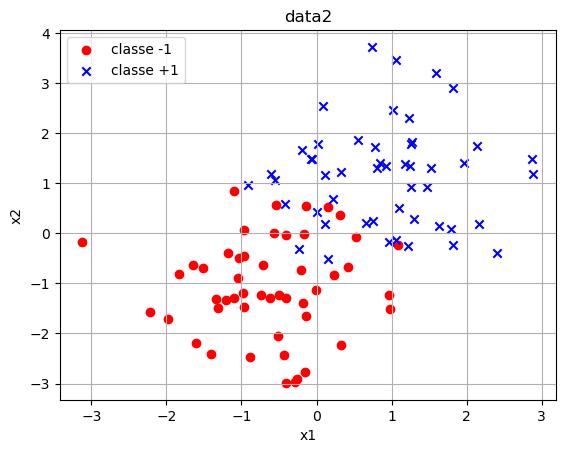

In [25]:
# Exemple d'utilisation:
np.random.seed(42)   # on prend 42 comme graine

data_gauss_desc, data_gauss_label = genere_dataset_gaussian(np.array([1,1]),np.array([[1,0],[0,1]]), \
                                                            np.array([-0.5,-1]),np.array([[1,0],[0,1]]), \
                                                            50)

print("Taille du dataset généré :", np.shape(data_gauss_desc), "exemples")
print("Rappel: les exemples de labels -1 sont en rouge, ceux de labels +1 sont en bleu.")

# Affichage :
plot2DSet(data_gauss_desc, data_gauss_label, "data_gauss")


In [ ]:
print("Nombre d'exemples dans ce dataset: " + str(len(data_gauss_desc)))

Nombre d'exemples dans ce dataset: 100


In [27]:
# Quelques exemples et fonctions utiles :
np.random.seed(42)
v = np.random.uniform(-1,1,2)

print("Vecteur v: ",v)
# Quelques fonctions numpy utiles:

# norme euclidienne de v:
print("Norme euclidienne de v: ",np.linalg.norm(v))

v2 = np.array([0.5, 0.5])
print("Un autre vecteur v2: ",v2,"\tet sa norme: ",np.linalg.norm(v2))

v3 = v / np.linalg.norm(v)
print("Un dernier vecteur v3: ",v3,"\tet sa norme: ",np.linalg.norm(v3))


Vecteur v:  [-0.25091976  0.90142861]
Norme euclidienne de v:  0.935699883042433
Un autre vecteur v2:  [0.5 0.5] 	et sa norme:  0.7071067811865476
Un dernier vecteur v3:  [-0.26816265  0.96337365] 	et sa norme:  1.0


## Étape 2: les classifieurs

Un classifieur (binaire dans ce cours) permet, pour chaque point d'entrée donné, de calculer un **score** (qui est une valeur de $\mathbb{R}$) pour déterminer la classe d'un exemple. Cette classe est donnée par le signe de ce score: si le score est strictement négatif, la donnée est associée à la classe (ou label) $-1$, sinon elle est associée à classe (ou label) $+1$. 


### Représentation orientée objets

En LU3IN026, pour implémenter nos algorithmes d'apprentissage, nous allons utiliser quelques éléments de programmation orientée objet (POO) qu'autorise le langage Python. 

Si vous ne connaissez rien à la POO, il est fortement conseillé de vous familiariser avec elle, par exemple en commençant par lire une documentation ou suivre un tutorial sur le web (par exemple, https://courspython.com/classes-et-objets.html).


### La classe Classifier

<div class="alert alert-block alert-warning">
    
Les différents classifieurs que l'on va implémenter seront dérivés d'une classe unique : la classe `Classifier` qui est donnée ci-dessous. Pour nous, cette classe est l'équivalent une classe abstraite de Java, elle sera dérivée par héritage pour définir des classifieurs particuliers qui seront vus ce semestre (knn, perceptron, arbres de décision, etc.) et qui devront implémenter toutes les méthodes de cette classe. On aura ainsi un moyen générique d'accéder à nos classifieurs.

La classe `Classifier` contient 5 méthodes:
- `__init__`: (le constructeur) qui permet d'initialiser les paramètres du classifieur. Les classes filles étendront donc cette méthode en rajoutant les paramètres qui les concernent. Le paramètre obligatoire à donner à la création d'un classifieur est le nombre de dimensions des données qu'il aura à traiter et qui est défini et initialisé dans cette classe (attribut: `self.dimension`).
- `train`: c'est la méthode qui permet d'entraîner le modèle, on doit donc donner en argument le dataset qui sert à l'entraînement.
- `score`: cette méthode est utilisée une fois le classifieur entrainé. Elle prend en argument la description d'un exemple et elle rend un score (qui est donc une valeur de $\mathbb{R}$).
- `predict`: cette méthode, comme la précédente, s'utilise une fois le classifieur entraîné. Elle rend $\hat y$, le label (-1 ou +1) qui est prédit par le classifieur pour la description de l'exemple donnée en argument. Généralement, cette valeur de prédiction $\hat y$ s'obtient à partir du score: si le score est strictement négatif $\hat y$ vaut  $-1$, sinon il vaut $+1$.
- `accuracy`: comme les 2 précédentes, cette méthode s'utilise une fois le classifieur entraîné. Elle permet de calculer la qualité du classifieur qui est mesurée par le **taux de bonne classification** du classifieur sur le dataset donné en argument. C'est une valeur de $[0,1]$ qui s'obtient divisant le nombre d'exemples du dataset qui sont bien classés par le classifieur par le nombre total d'exemples du dataset.

Les méthodes `train`, `score` et `predict` dépendent du classifieur que l'on implémente, elle ne seront pas définies dans la classe `Classifier` mais dans les classes qui hériteront ce cette classe.

Par contre, la fonction `accuracy` peut être définie dès maintenant dans cette classe `Classifier`.
</div>

<font color="RED" size="+1">**[Q]**</font> Compléter la classe `Classifier` ci-dessous en donnant l'implémentation de la fonction `accuracy`. Penser à déjà bien examiner les méthodes existantes dans la classe (et que l'on peut utiliser avant qu'elles soient implémentées).

In [70]:
# ------------------------ A COMPLETER :
class Classifier:
    """ Classe (abstraite) pour représenter un classifieur
        Attention: cette classe est ne doit pas être instanciée.
    """
    
    def __init__(self, input_dimension):
        """ Constructeur de Classifier
            Argument:
                - intput_dimension (int) : dimension de la description des exemples
            Hypothèse : input_dimension > 0
        """
        self.dimension = input_dimension
        
    def train(self, desc_set, label_set):
        """ Permet d'entrainer le modele sur l'ensemble donné
            desc_set: ndarray avec des descriptions
            label_set: ndarray avec les labels correspondants
            Hypothèse: desc_set et label_set ont le même nombre de lignes
        """        
        raise NotImplementedError("Please Implement this method")
    
    def score(self,x):
        """ rend le score de prédiction sur x (valeur réelle)
            x: une description
        """
        raise NotImplementedError("Please Implement this method")
    
    def predict(self, x):
        """ rend la prediction sur x (soit -1 ou soit +1)
            x: une description
        """
        raise NotImplementedError("Please Implement this method")

    def accuracy(self, desc_set, label_set):
        """ Permet de calculer la qualité du système sur un dataset donné
            desc_set: ndarray avec des descriptions
            label_set: ndarray avec les labels correspondants
            Hypothèse: desc_set et label_set ont le même nombre de lignes
        """
        cpt = 0
        for i in range(len(label_set)):
            if self.predict(desc_set[i]) == label_set[i]:
                cpt += 1

        return cpt / len(label_set)

# les $k$-plus proches voisins (*$k$-ppv* ou *$k$-NN*)


<div class="alert alert-block alert-info">
    
Le classifieur des $k$-plus proches voisins (en anglais: $k$-nearest neighbors) est très intuitif: il s'agit de prédire la classe majoritaire dans le voisinage d'un point en examinant ses $k$ plus proches voisins (au sens d'une distance donnée, en général la distance euclidienne).
La figure ci-dessous illustre bien le principe général de l'algorithme:

<a href="https://fr.wikipedia.org/wiki/Méthode_des_k_plus_proches_voisins#/media/Fichier:KnnClassification.svg"><img src='ressources/Knn.png' width=300px></a>

La classe à prédire pour l'exemple représenté par un point vert est celle qui est majoritaire parmi ses $k$ voisins les plus proches.

Cet algorithme d'apprentissage est particulier: l'apprentissage consiste simplement à stocker la base d'apprentissage en mémoire (dans un attribut du classifieur donc) pour les réutiliser plus tard.

En contrepartie, l'inférence pour faire une prédictiopn coûte très cher: pour chaque prédiction , il faut analyser tout le dataset stocké afin de trouver les $k$ plus proches voisins de l'exemple à prédire.
</div>   

<div class="alert alert-block alert-warning">
    
Description de la classe `ClassifierKNN` (qui étend `Classifier`):
- dans le constructeur, on précise, en plus de la dimension du dataset, le nombre de voisins à utiliser (c'est la valeur $k$).
- dans la méthode `train`, on donne le dataset qui doit servir de dataset de référence et qui est donc stocké en tant qu'attribut.
- dans la méthode `score`, pour une description d'exemple $\mathbf{x}$ donnée :
    - 1) on construit le tableau des distances entre $\mathbf{x}$ et les exemples du dataset de référence, 
    - 2) on trie ce tableau grâce, par exemple, à la méthode numpy `argsort`,
    - 3) le score qui doit être rendu est calculé à partir de **la proportion d'exemples de classe +1** parmi les $k$ plus proches voisins de $x$. Le score 
        - vaut $0$ si la proportion est d'exactement $50\%$ d'exemples de classe +1 parmi les $k$ plus proches voisins;
        - est strictement inférieur à $0$ si la proportion est strictement inférieure à $50\%$. Il est d'autant plus négatif que la proportion est faible;
        - est strictement supérieur à $0$ si la proportion est strictement supérieur à $50\%$. Il est d'autant plus grand que la proportion est importante. <br>
    Par exemple, le score peut se calculer à partir de $p \in [0,1]$, la proportion d'exemples, par $2(p-0.5)$.
- dans la méthode `predict`, pour une description d'exemple $\mathbf{x}$ donnée, on utilise le score rendu par la fonction précédente pour rendre la classe de l'exemple, c'est-à-dire soit $-1$ soit $+1$. 
</div>

<font color="RED" size="+1">**[Q]**</font> Compléter le code de la classe `ClassifierKNN` 

In [71]:
# ------------------------ A COMPLETER :

class ClassifierKNN(Classifier):
    """ Classe pour représenter un classifieur par K plus proches voisins.
        Cette classe hérite de la classe Classifier
    """

    # ATTENTION : il faut compléter cette classe avant de l'utiliser !
    
    def __init__(self, input_dimension, k):
        """ Constructeur de Classifier
            Argument:
                - intput_dimension (int) : dimension d'entrée des exemples
                - k (int) : nombre de voisins à considérer
            Hypothèse : input_dimension > 0
        """
        Classifier.__init__(self,input_dimension)
        self.k = k
        self.desc_set = None
        self.label_set = None

        
    def score(self,x):
        """ rend la proportion de +1 parmi les k ppv de x (valeur réelle)
            x: une description : un ndarray
        """
        distances = np.linalg.norm(self.desc_set - x, axis=1) #vecteur des distances entre x et tous les pts de desc_set
        distances = np.argsort(distances)
        kppv = self.label_set[distances[:self.k]] #k plus proches
        proportion_1 = np.sum(kppv == 1) / self.k #proportion de +1
        if proportion_1 == 0.5 :
            return 0
        else:
            return 2*(proportion_1-0.5)
    
    def predict(self, x):
        """ rend la prediction sur x (-1 ou +1)
            x: une description : un ndarray
        """
        if self.score(x) > 0 :
            return 1
        return -1


    def train(self, desc_set, label_set):
        """ Permet d'entrainer le modele sur l'ensemble donné
            desc_set: ndarray avec des descriptions
            label_set: ndarray avec les labels correspondants
            Hypothèse: desc_set et label_set ont le même nombre de lignes
        """        
        self.desc_set = desc_set
        self.label_set = label_set  


In [72]:
# Pour avoir les mêmes valeurs aléatoires :
np.random.seed(42)  

# Création d'un classifieur KNN de dimension 2 et avec k qui vaut 1:
un_KNN = ClassifierKNN(2,1)

# Entraînement du classifieur (appel de sa méthode train avec le dataset d'apprentissage)
tic = time.time()   # On chronomètre le temps mis pour apprendre
un_KNN.train(data2_desc,data2_label)
toc = time.time()
print(f'Apprentissage en {(toc-tic):1.5f} secondes')

# Classification du dataset (contrôle de predict et score):
print("Classification des exemples du dataset:")

for i in range(0,20):
    print("\t{0:+.3f} {1:+.3f} : {2:+} ---> classe prédite: {3:+}\t [score = {4:+.2f}]".format(data2_desc[i,:][0], data2_desc[i,:][1], \
                                                                  data2_label[i], \
                                                                  un_KNN.predict(data2_desc[i,:]), \
                                                                  un_KNN.score(data2_desc[i,:])) )

# Affichage du taux de bonne classification   
tic = time.time() # On chronomètre le temps mis pour calculer l'accuracy sur le dataset
val_accuracy = un_KNN.accuracy(data2_desc,data2_label)
toc = time.time()

print(f'Calcul de l\'accuracy du dataset ({data2_desc.shape[0]} exemples) en {(toc-tic):1.5f} secondes')

print(f'Taux de bonne classification sur le dataset: {val_accuracy:1.3f}')   


Apprentissage en 0.00000 secondes
Classification des exemples du dataset:
	-1.255 +4.507 : -1 ---> classe prédite: -1	 [score = -1.00]
	+2.320 +0.987 : -1 ---> classe prédite: -1	 [score = -1.00]
	-3.440 -3.440 : -1 ---> classe prédite: -1	 [score = -1.00]
	-4.419 +3.662 : -1 ---> classe prédite: -1	 [score = -1.00]
	+1.011 +2.081 : -1 ---> classe prédite: -1	 [score = -1.00]
	-4.794 +4.699 : -1 ---> classe prédite: -1	 [score = -1.00]
	+3.324 -2.877 : -1 ---> classe prédite: -1	 [score = -1.00]
	-3.182 -3.166 : -1 ---> classe prédite: -1	 [score = -1.00]
	-1.958 +0.248 : -1 ---> classe prédite: -1	 [score = -1.00]
	-0.681 -2.088 : -1 ---> classe prédite: -1	 [score = -1.00]
	+1.119 -3.605 : +1 ---> classe prédite: +1	 [score = +1.00]
	-2.079 -1.336 : +1 ---> classe prédite: +1	 [score = +1.00]
	-0.439 +2.852 : +1 ---> classe prédite: +1	 [score = +1.00]
	-3.003 +0.142 : +1 ---> classe prédite: +1	 [score = +1.00]
	+0.924 -4.535 : +1 ---> classe prédite: +1	 [score = +1.00]
	+1.075 -3.

<font color="RED" size="+1">**[Q]**</font> Calculer la performance (*accuracy*) d'un classifeur KNN qui apprend sur un dataset de 40 exemples générés selon une loi gaussienne et évaluer sa performance sur un autre dataset de test contenant de 1000 autres exemples générés aussi de selon une loi gaussienne.


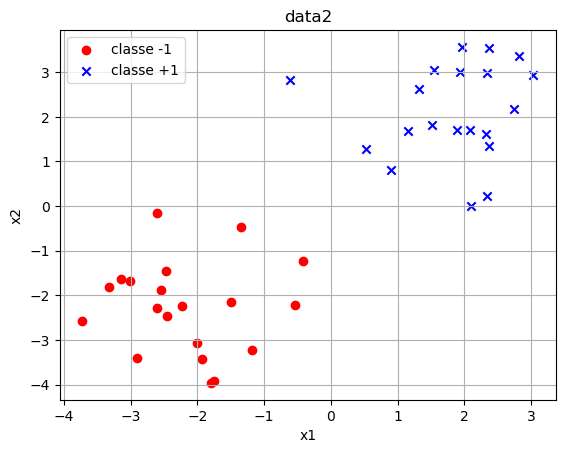

Apprentissage en 0.00000 secondes
Calcul de l'accuracy du dataset (1000 exemples) en 0.00100 secondes
Taux de bonne classification sur le dataset test_gauss_desc: 1.000


In [73]:
np.random.seed(42)   # on prend 42 comme graine

train_gauss_desc, train_gauss_label = genere_dataset_gaussian(positive_center=np.array([2, 2]),positive_sigma=np.array([[1, 0], [0, 1]]), 
negative_center=np.array([-2, -2]), negative_sigma=np.array([[1, 0], [0, 1]]), nc=20)

test_gauss_desc, test_gauss_label = genere_dataset_gaussian(positive_center=np.array([2, 2]),positive_sigma=np.array([[1, 0], [0, 1]]), 
negative_center=np.array([-2, -2]), negative_sigma=np.array([[1, 0], [0, 1]]), nc=500)


# Affichage :
plot2DSet(train_gauss_desc, train_gauss_label, "train_gauss")

# Création d'un classifieur KNN de dimension 2 et avec k qui vaut 1
autre_KNN =  ClassifierKNN(2,1)

# Entraînement du classifieur
tic = time.time()   
autre_KNN.train(train_gauss_desc, train_gauss_label)
toc = time.time()
print(f'Apprentissage en {(toc-tic):1.5f} secondes')

# Affichage du taux de bonne classification   
tic = time.time() 
val_accuracy =  autre_KNN.accuracy(train_gauss_desc, train_gauss_label)
toc = time.time()

print(f'Calcul de l\'accuracy du dataset ({test_gauss_desc.shape[0]} exemples) en {(toc-tic):1.5f} secondes')

print(f'Taux de bonne classification sur le dataset test_gauss_desc: {val_accuracy:1.3f}')   


<font color="RED" size="+1">**[Q]**</font> Tracer la courbe qui donne l'évaluation de l'accuracy obtenue par un classifieur KNN de dimension $k$ entraîné et testé sur les données précédentes, lorsque $k$ varie de 1 à 39.

Remarque: ne considérer que les valeurs impaires pour $k$.


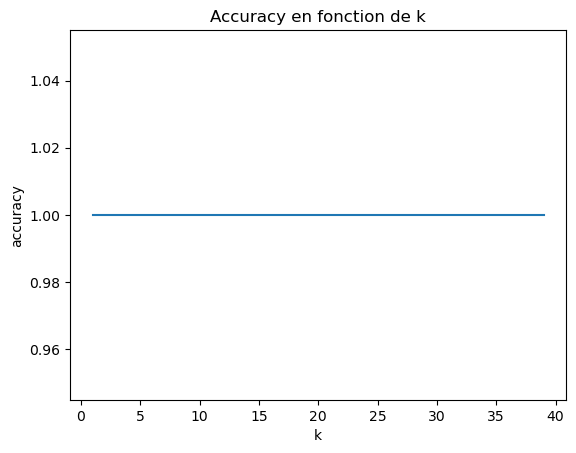

In [74]:
# pour mémoriser les accuracies pour chaque k:
L_accuracies = []

for k in range(1, 40, 2):
    knn = ClassifierKNN(2, k)
    knn.train(train_gauss_desc, train_gauss_label)
    L_accuracies.append(knn.accuracy(train_gauss_desc, train_gauss_label))

# -------------------------------------------------
plt.plot(list(range(1, 40, 2)), L_accuracies)
plt.xlabel("k")
plt.ylabel("accuracy")
plt.title("Accuracy en fonction de k")
plt.show()

## Visualisation du classifieur

Nous allons maintenant essayer d'analyser le comportement du classifieur. La première étape consiste à analyser graphiquement la décision par rapport aux données. <BR>
**ATTENTION** Ce n'est possible qu'en 2 dimensions


Voici une fonction qui permet de dessiner la frontière de décision d'un classifieur. La valeur `step` permet de choisir la précision de tracé du dessin.
Le code est entièrement fourni mais pour information, l'idée est la suivante:
1. générer une grille de points sur tout l'espace;
1. évaluer le classifieur sur toute la grille;
1. interpoler un niveau de couleur sur tout l'espace représentant les valeurs du classifieur.

In [75]:
def plot_frontiere(desc_set, label_set, classifier, step=30):
    """ desc_set * label_set * Classifier * int -> NoneType
        Remarque: le 4e argument est optionnel et donne la "résolution" du tracé: plus il est important
        et plus le tracé de la frontière sera précis.        
        Cette fonction affiche la frontière de décision associée au classifieur
    """
    mmax=desc_set.max(0)
    mmin=desc_set.min(0)
    x1grid,x2grid=np.meshgrid(np.linspace(mmin[0],mmax[0],step),np.linspace(mmin[1],mmax[1],step))
    grid=np.hstack((x1grid.reshape(x1grid.size,1),x2grid.reshape(x2grid.size,1)))
    
    # calcul de la prediction pour chaque point de la grille
    res=np.array([classifier.predict(grid[i,:]) for i in range(len(grid)) ])
    res=res.reshape(x1grid.shape)
    # tracer des frontieres
    # colors[0] est la couleur des -1 et colors[1] est la couleur des +1
    plt.contourf(x1grid,x2grid,res,colors=["darksalmon","skyblue"],levels=[-1000,0,1000])

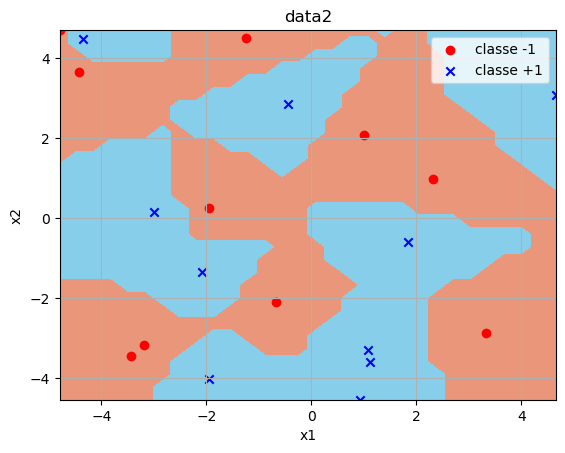

In [76]:
# Affichage de la frontière de séparation des classes
plot_frontiere(data2_desc,data2_label,un_KNN)
plot2DSet(data2_desc,data2_label,"data2"+" avec une taille de pas de "+str(30))

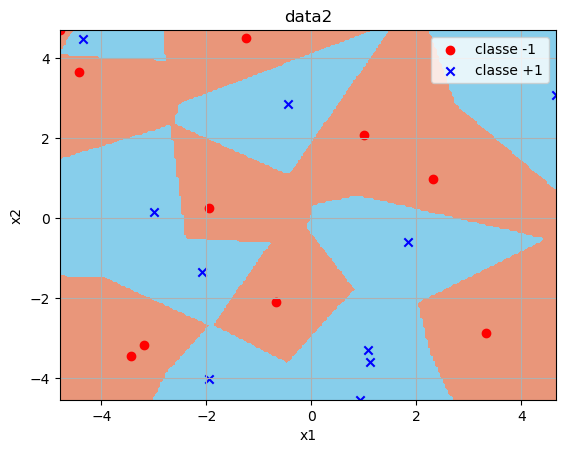

In [77]:
# Affichage de la frontière de séparation des classes
# On met une valeur de "step" importante : cela permet un affichage plus précis
# Attention : le temps d'exécution sera plus important !
plot_frontiere(data2_desc,data2_label,un_KNN,step=200)
plot2DSet(data2_desc,data2_label,"data2"+" avec une taille de pas de "+str(200))

<font color="RED" size="+1">**[Q]**</font>Tracer la frontière de séparation des classes de votre knn `autre_KNN` pour le dataset `data_gauss_desc` avec $k$ égal à 1.


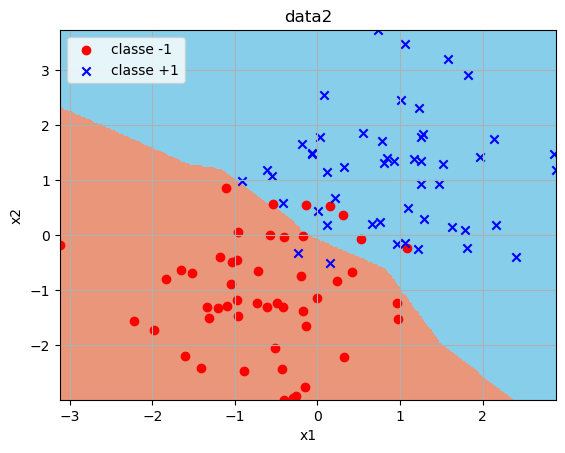

Accuracy:  0.92


In [78]:
# Pour avoir les mêmes valeurs aléatoires :
np.random.seed(42)   # supprimer cette ligne une fois la mise au point terminée

# Affichage de la frontière de séparation des classes
plot_frontiere(data_gauss_desc, data_gauss_label,autre_KNN, step=200)
plot2DSet(data_gauss_desc, data_gauss_label,"data_gauss avec un knn de k="+str(autre_KNN.k))

# Performance de ce classifieur:
print("Accuracy: ",autre_KNN.accuracy(data_gauss_desc, data_gauss_label))

<font color="RED" size="+1">**[Q]**</font>Tracer la frontière de séparation des classes d'un knn entraîné toujours sur le dataset `data_gauss_desc` mais défini en prenant $k$ égal à 5.

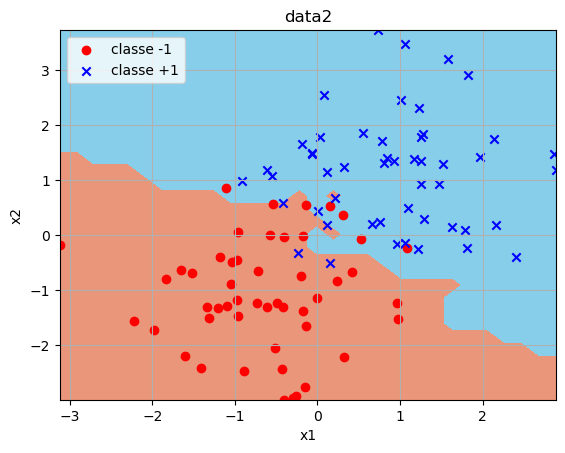

Accuracy:  0.89


In [79]:
# Création d'un knn avec k=5 et 2 dimensions pour les données
classifierKNN2 = ClassifierKNN(2,5)

# Entraînement du classifier:
classifierKNN2.train(data_gauss_desc, data_gauss_label)

# Affichage de la frontière de séparation des classes
plot_frontiere(data_gauss_desc, data_gauss_label,classifierKNN2)
plot2DSet(data_gauss_desc, data_gauss_label,"data_gauss avec un knn de k="+str(classifierKNN2.k))

# Performance de ce classifieur:
print("Accuracy: ",classifierKNN2.accuracy(data_gauss_desc, data_gauss_label))

<font color="RED" size="+1">**[Q]**</font> Etudier les différences qui existent entre la frontière de séparation des classes obtenue avec le kppv k=1 et celle obtenue avec le kppv k=5. Proposer un tracé à la main de la frontière pour différentes valeurs de k.

## Un classifieur linéaire

Nous allons maintenant définir un **classifieur linéaire aléatoire** en étendant la classe `Classifier` et en implémentant le constructeur ainsi que les 3 méthodes `predict`, `score` et `train`.

Ce classifieur est un des plus simple que l'on puisse construire: on génère aléatoirement une droite (ou hyperplan si on a plus de 2 dimensions) dans l'espace des dimensions en tirant aléatoirement un vecteur $w$ donnant les coefficients de chaque dimensions. L'équation de la droite (hyperplan) est alors donnée par $\langle x, w\rangle = 0$ (cf. TD de la semaine 1).

Cela nous permis de construire un vecteur de poids. Cette droite est utilisée pour classer les exemples: d'un côté de la droite ils sont prédits de la classe +1, de l'autre côté ils sont prédits de la classe -1.

Naturellement, ce classifieur a de bonnes chances de ne pas être très efficace...


<div class="alert alert-block alert-info">

Pour un classifieur linéaire aléatoire:
- dans le constructeur, on doit générer aléatoirement un vecteur $w$ de taille `input_dimension` de valeurs dans $[-1,1]$. Les poids doivent ensuite normalisés (c'est-à-dire que la norme de $w$ doit être égale à 1). Ainsi, si $v$ est le vecteur aléatoire à valeurs dans $[-1,1]$ généré, on obtient un vecteur $w$ normalisé à partir de $v$ en prenant chaque composante de $v$ est en la divisant par la norme de $v$.
- pour ce classifieur, la méthode `train` ne fait rien. On ne mettra qu'un print permettant d'afficher le message "Pas d'apprentissage pour ce classifieur"
- pour une description d'exemple $x$, la méthode `score` rend la valeur de $\langle x, w\rangle$
- pour une description d'exemple $x$, la méthode `predict` doit utiliser la valeur de $\langle x, w\rangle$ pour prédire le label (+1 ou -1) associé
</div>

<font color="RED" size="+1">**[Q]**</font> Compléter l'implémentation suivante de la classe <code>ClassifierLineaireRandom</code> qui hérite de `Classifier` et permet de définir un classifieur linéaire aléatoire.

Les entrées/sorties sont les bonnes à chaque étape... Mais il n'y a pas d'apprentissage: $w$ est donc aléatoire (mais il doit être à la bonne dimension pour les calculs soient possibles) et déterminé à la création du classifieur.

In [80]:
# ------------------------ A COMPLETER :
class ClassifierLineaireRandom(Classifier):
    """ Classe pour représenter un classifieur linéaire aléatoire
        Cette classe hérite de la classe Classifier
    """
    
    def __init__(self, input_dimension):
        """ Constructeur de Classifier
            Argument:
                - intput_dimension (int) : dimension de la description des exemples
            Hypothèse : input_dimension > 0
        """
        Classifier.__init__(self,input_dimension)
        v = np.random.uniform(-1, 1, input_dimension)
        self.w = v / np.linalg.norm(v)        

    def train(self, desc_set, label_set):
        """ Permet d'entrainer le modele sur l'ensemble donné
            desc_set: ndarray avec des descriptions
            label_set: ndarray avec les labels correspondants
            Hypothèse: desc_set et label_set ont le même nombre de lignes
        """        
        print("Pas d'apprentissage pour ce classifieur")

    def score(self,x):
        """ rend le score de prédiction sur x (valeur réelle)
            x: une description
        """
        return np.dot(x, self.w)
    
    def predict(self, x):
        """ rend la prediction sur x (soit -1 ou soit +1)
            x: une description
        """
        if self.score(x) > 0:
            return 1
        return -1    

Utilisation de la classe ainsi créée:

In [81]:
# Pour avoir les mêmes valeurs aléatoires :
np.random.seed(42)   # supprimer cette ligne une fois la mise au point terminée

# Création d'un classifieur linéaire aléatoire de dimension 2:
lin_alea = ClassifierLineaireRandom(2)

# Par définition, ce classifieur n'a pas besoin d'entraînement
lin_alea.train(data1_desc,data1_label)

# Classification du dataset (contrôle de predict et score):
print("Classification du dataset:")

# Affichage du taux de bonne classification    
print("Taux de bonne classification sur le dataset: ", lin_alea.accuracy(data1_desc,data1_label))   


Pas d'apprentissage pour ce classifieur
Classification du dataset:
Taux de bonne classification sur le dataset:  0.48


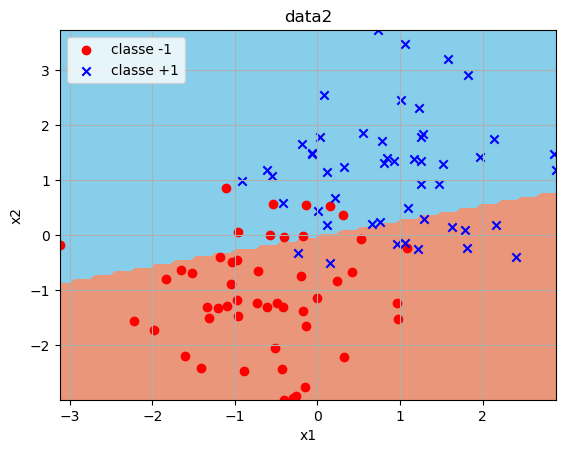

In [82]:
# Affichage de la frontière de séparation des classes
plot_frontiere(data_gauss_desc,data_gauss_label,lin_alea,step=100)
plot2DSet(data_gauss_desc,data_gauss_label,"data_gauss avec classifieur linéaire aléatoire")

## Données réelles UCI & USPS

Plusieurs datasets sont récupérables directement en python depuis la bibliothèque scikit-learn:
https://scikit-learn.org/stable/api/sklearn.datasets.html

Il est aussi possible de jouer avec les données USPS (chiffres manuscrits) qui ont été présentées en cours.
Dans la suite, nous vous proposons une petite étude sur USPS.


<font color="RED" size="+1">**[Q]**</font> Charger les données (le code est fourni) puis isoler les 1 et les 2 pour créer un problème binaire.

Pour cette sélection de données en numpy, il peut être intéressant de faire appel à la fonction numpy `where`

In [ ]:
import pickle as pkl

data = pkl.load(open('data/usps.pkl', 'rb'))
X = np.array(data['X_train'], dtype=float) # conversion de type pour une meilleure compatibilité
Y = np.array(data['Y_train'], dtype=float)
print(data['Y_train'])
# ------------------------ A COMPLETER :
# reduction du jeu de données

# X12 = 
# Y12 =  # encoder en -1/1



{'X_train': array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0.2, 0. , 0. ]], dtype=float16), 'X_test': array([[0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       ...,
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.331, 0.   , 0.   ]], dtype=float16), 'Y_train': array([0, 9, 7, ..., 6, 3, 2], dtype=int64), 'Y_test': array([2, 0, 0, ..., 1, 8, 3], dtype=int64)}


TypeError: 'NoneType' object is not subscriptable

<font color="RED" size="+1">**[Q]**</font> Prise en main des données:
1. Afficher les dimensions des données. Quel est l'espace de description des données?
1. Afficher la première image du jeu de données en utilisant `reshape` et `imshow` comme vu en cours.
1. Donner l'histogramme d'illumination du premier pixel (0) puis pour le pixel 219. Analyser le résultat
1. Sur le pixel 219, afficher l'histogramme des illuminations pour la classe 1 et pour la classe 2: vous semble-il possible de classer les données sur la base de cette seule information? Quel serait le taux de bonne classification?


<font color="RED" size="+1">**[Q]**</font> Construire un classifieur linéaire aléatoire pour ces données en utilisant le code précédent. Evaluer les performances.

Le but de cette question est de vérifier que votre code n'est pas dépendant des dimensions des données: il doit s'adapter aux 256 dimensions des chiffres.

<font color="RED" size="+1">**[Q]**</font> Application du classifieur des $k$-plus proches voisins sur `X12` avec $k=7$. Evaluer les performances de votre classifieur

<font color="RED" size="+1">**[Q]**</font> Que se passe-t-il si on construit un knn avec $k=1$? Que va donner le taux de bonne classification? 

Ce résultat est-il satisfaisant? 

Dans le dictionnaire `data` chargé depuis `usps.pkl`, il existe un ensemble d'exemples de test:

In [100]:
X_test = np.array(data['X_test'], dtype=float)
Y_test = np.array(data['Y_test'], dtype=float)

Comme pour construire `X12` et `Y12`, extraire de ces données les exemples de label 1 et de label 2.

In [102]:
# ------------------------ A COMPLETER :
# reduction du jeu de données

# X12_test = 
# Y12_test =



Donner l'accuracy d'un classifieur knn avec $k=1$ qui apprend sur les données d'apprentissage (précédentes) et qui est évalué sur ces données test.

<font color="RED" size="+1">**[Q]**</font> Que pouvez-vous en conclure ?

### Pour aller plus loin...

<font color="RED" size="+1">**[Q]**</font> Proposer une nouvelle version de classifieur $k$-ppv capable de fonctionner pour des problèmes multi-classes, c'est-à-dire quand il existe $C$ classes. Tester les performances de ce nouveau classifieur sur les données USPS.

Tenter des modifications sur les données (binarisation, suppression des colonnes de trop forte entropie...) et étudier l'impact sur les performances.

In [ ]:
# Exemple d'utilisation : (attention: le temps de calcul peut être long !)

class_mc = ClassifierKNN_MC(256,5,10)
class_mc.train(X, Y)

print("KNN avec k=10:")
print("Taux de bonne classification sur le dataset: {0:1.5f}".format(class_mc.accuracy(X_test,Y_test)))
